# Portfolio 3 , Methods 3, 2021, autumn semester
### Laura W. Paaby
### 1/12 - 2021

# Exercises and objectives
1) Load the magnetoencephalographic recordings and do some initial plots to understand the data
2) Do logistic regression to classify pairs of PAS-ratings
3) Do a Support Vector Machine Classification on all four PAS-ratings
REMEMBER: In your report, make sure to include code that can reproduce the answers requested in the
exercises below (MAKE A KNITTED VERSION)
REMEMBER: This is Assignment 3 and will be part of your final portfolio

# EXERCISE 1 - Load the magnetoencephalographic recordings and do some initial plots to understand the data

1) Load megmag_data.npy and call it data using np.load. You can use join, which can be imported
from os.path, to create paths from different string segments
i. The data is a 3-dimensional array. The first dimension is number of repetitions of a visual stimulus, the second dimension is the number of sensors that record magnetic fields (in Tesla) that stem from neurons activating in the brain, and the third dimension is the number of time samples. How many repetitions, sensors and time samples are there?

In [1]:
## importing libraries
import statistics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import train_test_split
import scipy as sp
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import os

In [2]:
#data = np.load("/Users/laura/Desktop/megmag_data.npy")

import requests
import io

response = requests.get('http://laumollerandersen.org/data_methods_3/megmag_data.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content))

#numbers of repitions of visual stimuli: 682
#numbers of sensors (spots in the cap that record magnetic fields): 102
#numbers of time samples: 251
#### this is found by:
print(data.shape)

(682, 102, 251)


ii. The time range is from (and including) -200 ms to (and including) 800 ms with a sample recorded every 4 ms. At time 0, the visual stimulus was briefly presented. Create a 1-dimensional array called `times` that represents this.  

In [3]:
#creating array of time samples:
time_array = np.arange(-200, 804, 4)

iii. Create the sensor covariance matrix $\Sigma_{XX}$: $$\Sigma_{XX} = \frac 1 N \sum_{i=1}^N XX^T$$ $N$ is the number of repetitions and $X$ has $s$ rows and $t$ columns (sensors and time), thus the shape is $X_{s\times t}$. Do the sensors pick up independent signals? (Use `plt.imshow` to plot the sensor covariance matrix)  

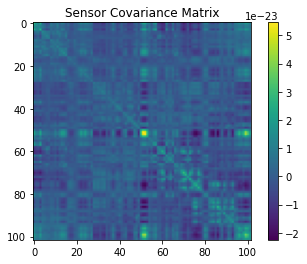

In [4]:
n = 682
cov_mat = []

#calculating the dot product for all rows i using all datapoints in the dimensions
for i in range(n):
    cov_mat.append(data[i,:,:] @ data[i,:,:].T)

#out of the loop the dot product of the the matrices for each i is summed and divided by n.
cov_mat = sum(cov_mat)/n

#plotting the covariance matrix
plt.imshow(cov_mat)
plt.title("Sensor Covariance Matrix")
plt.colorbar()
plt.show()

*The plot here is hard to interpret, due to the amount of pixels.* 
*However, some areas seem to be troubeling having a rather high covariance (the colours are not around 0 according to the colourscale).*

iv. Make an average over the repetition dimension using `np.mean` - use the `axis` argument. (The resulting array should have two dimensions with time as the first and magnetic field as the second)  

In [5]:
### we take the mean of all the repetions, the first axis = 0 - this now gives us all the values for sensors and time samples in this exact point (the mean) on the repetition axes 
rep_mean = np.mean(data, axis=0)
###this should be transposed ?????
print(rep_mean.shape)

(102, 251)


 v. Plot the magnetic field (based on the average) as it evolves over time for each of the sensors (a line for each) (time on the x-axis and magnetic field on the y-axis). Add a horizontal line at $y = 0$ and a vertical line at $x = 0$ using `plt.axvline` and `plt.axhline`  

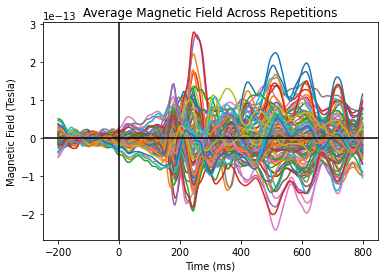

In [6]:
plt.figure()
plt.plot(time_array, rep_mean.T) #taking the transposed gives the same as if we loop over all the teslas
plt.title("Average Magnetic Field Across Repetitions")
plt.xlabel("Time (ms)")
plt.ylabel("Magnetic Field (Tesla)")
plt.axvline(0,0, color = "black")
plt.axhline(0,0, color = "black")
plt.show()  


 vi. Find the maximal magnetic field in the average. 
Then use `np.argmax` and `np.unravel_index` to find the sensor that has the maximal magnetic field. 

In [40]:
#finding the max - but this gives a coordinate in the dataframe of mean times:
maxi_mag = np.unravel_index(np.argmax(rep_mean), rep_mean.shape)
print(maxi_mag) #sensor 73, repition 112
#the coordinates can be printed as a number:
print("the value of the maximal of magnetic field:",rep_mean[73,112])
# = 2.7886216843591933e-13 which is a super small number, yet it is our maximum. 

(73, 112)
the value of the maximal of magnetic field: 2.7886216843591933e-13


vii. Plot the magnetic field for each of the repetitions (a line for each) for the sensor that has the maximal magnetic field. Highlight the time point with the maximal magnetic field in the average (as found in 1.1.v) using `plt.axvline`  


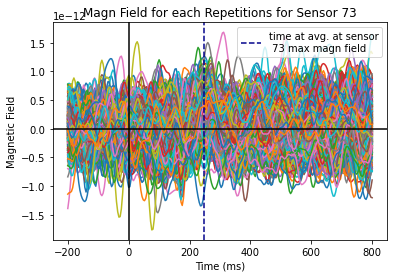

In [67]:
#first I save the sensor found to have the max mag field avg
sensor73 = data[:,73,:]

#now the times and repitions for this can be plottet (Taking one sensor only makes the data 2d, and now this is possible)
plt.figure()
plt.plot(time_array, sensor73.T)
plt.axvline(time_array[112], color = "darkblue", linestyle = "--", label = "time at avg. at sensor\n 73 max magn field")
plt.legend(loc = "upper right")
plt.axvline(color = "black")
plt.axhline(color = "black")
plt.title("Magn Field for each Repetitions for Sensor 73")
plt.xlabel("Time (ms)")
plt.ylabel("Magnetic Field")
plt.show()

#### we have plottet the 112 time *point*, which is not corresponding to the x axes, hence the line is not on x = 112


 viii. Describe in your own words how the response found in the average is represented in the single repetitions. 
But do make sure to use the concepts _signal_ and _noise_ and comment on any differences on the range of values on the y-axis:

*in this plot we no longer plot means, but all repition for sensor 73 (in the first we have all sensors but the mean repitions). In this plot it is very hard to interpret visually, since we cant distinct one line from another in this plot. It therefore does not really say much about the indiviudal repitions for sensor 73. In other words, the signal is rather hard to interpret due to the amount of noise this plot contains. However a few spikes in the magnetic fiels can still be spotted.*






### 2) Now load `pas_vector.npy` (call it `y`). 
#### PAS is the same as in Assignment 2, describing the clarity of the subjective experience the subject reported after seeing the briefly presented stimulus  

In [42]:
#vector_y = np.load("/Users/laura/Desktop/pas_vector.npy")

response = requests.get('http://laumollerandersen.org/data_methods_3/pas_vector.npy')
response.raise_for_status()
vector_y = np.load(io.BytesIO(response.content))

i. Which dimension in the `data` array does it have the same length as?  

In [43]:
print(vector_y.shape)

(682,)


 ii. Now make four averages (As in Exercise 1.1.iii), one for each PAS rating, and plot the four time courses (one for each PAS rating) for the sensor found in Exercise 1.1.v  

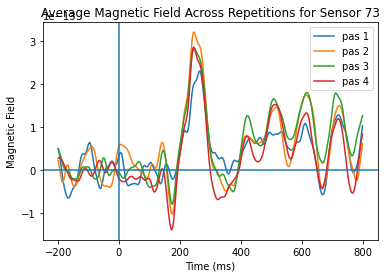

In [44]:
idx_1 = np.argwhere(vector_y == 1)
idx_2 = np.argwhere(vector_y == 2)
idx_3 = np.argwhere(vector_y == 3)
idx_4 = np.argwhere(vector_y == 4)

#making new df only for73
sensor73 = data[:,73,:]  
    
avgpas1 = np.mean(np.squeeze(sensor73[idx_1]), axis = 0)
avgpas2 = np.mean(np.squeeze(sensor73[idx_2]), axis = 0)
avgpas3 = np.mean(np.squeeze(sensor73[idx_3]), axis = 0)
avgpas4 = np.mean(np.squeeze(sensor73[idx_4]), axis = 0)

#plotting it 
plt.figure()
plt.plot(time_array, avgpas1)
plt.plot(time_array, avgpas2)
plt.plot(time_array, avgpas3)
plt.plot(time_array, avgpas4)
plt.axvline()
plt.axhline()
plt.legend(['pas 1', 'pas 2', 'pas 3', 'pas 4'])
plt.title("Average Magnetic Field Across Repetitions for Sensor 73")
plt.xlabel("Time (ms)")
plt.ylabel("Magnetic Field")
plt.show()

## this now show the mean of all magnitudes in the respective pass    


 iii. Notice that there are two early peaks (measuring visual activity from the brain), one before 200 ms and one around 250 ms. Describe how the amplitudes of responses are related to the four PAS-scores. Does PAS 2 behave differently than expected?  
 
 *first we notice how the pas1 curve fits the expectations: no perceptual experience leads to least amount of activity. In allignemnt with this logic we should expect the pas ratings to gradually increase in activation.*
 *However, PAS 2 appears to spike the most and have the highest magnitude. This is a bit odd, since you don't see the stimuli that clear. An idea could be that you therefore use a lot of brain capacity to perceive what is actually shown. This idea could have been investigated further, if we knew where the exact sensor where placed. Additionally we see how the PAS 4 line dives just before 200. This could might be explained by the activation just before perfectly perceiving the stimuli.*

 *what is PAS you ask?!?! - recap from our assignment 2 part 2: 1. No Experience, 2. Weak Glimpse, 3. Almost Clear Experience, 4. Clear Experience, are the ratings of the perceptual awareness scale.* 

#   EXERCISE 2 - Do logistic regression to classify pairs of PAS-ratings 

### 1) Now, we are going to do Logistic Regression with the aim of classifying the PAS-rating given by the subject  
 i. We'll start with a binary problem - create a new array called `data_1_2` that only contains PAS responses 1 and 2. Similarly, create a `y_1_2` for the target vector  

In [45]:
list_y = np.argwhere((vector_y ==1) | (vector_y == 2))
y_1_2 = vector_y[list_y]


#finding pas one and two of the data:
pas_one = [i for i, x in enumerate(vector_y) if x ==1 ]
#this list can now be used index the matching numbers out of the data - we should have 99 reps,since this is the amount of passes:
print(data[pas_one,:,:].shape)

## pas two 
pas_two = [i for i, x in enumerate(vector_y) if x == 2 ]
print(data[pas_two,:,:].shape)


#taking the target values for each pass and saved them into data_1_2
data_one = data[pas_one,:,:]
data_two = data[pas_two,:,:]
data_1_2 = np.squeeze(np.concatenate((data_one,data_two), axis = 0))


##looking at the length to make sure they are the same
print(data_1_2.shape)

(99, 102, 251)
(115, 102, 251)
(214, 102, 251)


ii. Scikit-learn expects our observations (`data_1_2`) to be in a 2d-array, which has samples (repetitions) on dimension 1 and features (predictor variables) on dimension 2. Our `data_1_2` is a three-dimensional array. Our strategy will be to collapse our two last dimensions (sensors and time) into one dimension, while keeping the first dimension as it is (repetitions). Use `np.reshape` to create a variable `X_1_2` that fulfils these criteria.  

In [46]:
X_1_2 = data_1_2.transpose(0,1,2).reshape(-1,data_1_2.shape[0])
print(X_1_2.shape)
#this appears to be right since the shape now is the collapsed data in the 25602 row and the 214 repitions are the columns. 


(25602, 214)


iii. Import the `StandardScaler` and scale `X_1_2` 

In [47]:
#reshapingen 
X_1_2_reshaped = X_1_2.reshape(214, 25602)


## splitting the data so we can test how well it classifies the test set:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_1_2_reshaped, y_1_2, test_size=0.2, random_state=0)

y_train = y_train.squeeze()
y_test = y_test.squeeze()

#making everything on the same scale
sc = StandardScaler()
sc.fit(X_1_2_reshaped)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

iv. Do a standard `LogisticRegression` - can be imported from `sklearn.linear_model` - make sure there is no `penalty` applied  

In [48]:
logR = LogisticRegression(penalty='none') # no regularisation
logR.fit(X_train_std, y_train)
print(logR.score(X_train_std, y_train))

1.0


 v. Use the `score` method of `LogisticRegression` to find out how many labels were classified correctly. Are we overfitting? Besides the score, what would make you suspect that we are overfitting?  

In [49]:
l_sc = (logR.score(X_test_std, y_test))
print("this means that", l_sc*100, "% of the classifications are correct. this is not very much, which might could be explained by overfitting of the test data. The model are therefore not generalisable, and classifies the test data quite badly. if the model was not overfitted to the train data, we would expect it to be a better classifier - maybe we should penalizzzzze it") 


this means that 55.81395348837209 % of the classifications are correct. this is not very much, which might could be explained by overfitting of the test data. The model are therefore not generalisable, and classifies the test data quite badly. if the model was not overfitted to the train data, we would expect it to be a better classifier - maybe we should penalizzzzze it


vi. Now apply the _L1_ penalty instead - how many of the coefficients (`.coef_`) are non-zero after this?  

In [50]:
log_l1 = LogisticRegression(penalty = 'l1', solver = 'liblinear') # set 
log_l1.fit(X_train_std, y_train)
print("the classification accuracy on the train set:",(log_l1.score(X_train_std, y_train))*100, "%")

print("the classification accuracy on the test set:", (log_l1.score(X_test_std, y_test))*100, "%")
print("now that we have fitted the new penalized model we can check how many of the coefficients are not equal to zero, this actually has a lower accuracy of classification") 

the classification accuracy on the train set: 100.0 %
the classification accuracy on the test set: 48.837209302325576 %
now that we have fitted the new penalized model we can check how many of the coefficients are not equal to zero, this actually has a lower accuracy of classification


*we here see how it is clearly overfitting, since it in the test scores a 100% classification accuracy and only around due to chance in the test*

In [51]:
#finding the zeros 
l1_coef = log_l1.coef_
zero = np.count_nonzero(l1_coef == 0)
print("the zeros:", zero) #this is the amounts of 0's 
non_zero = np.count_nonzero(l1_coef != 0)
print("the non zeros:", non_zero) #this is the amounts of non 0's 

the zeros: 25382
the non zeros: 220


vii. Create a new reduced $X$ that only includes the non-zero coefficients - show the covariance of the non-zero features (two covariance matrices can be made; $X_{reduced}X_{reduced}^T$ or $X_{reduced}^TX_{reduced}$ (you choose the right one)) . Plot the covariance of the features using `plt.imshow`. Compared to the plot from 1.1.iii, do we see less covariance?  

(220, 220)


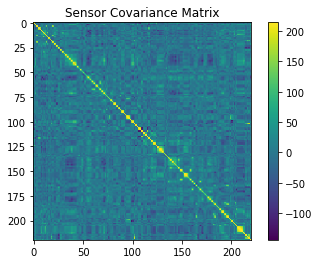

In [52]:
log1_coef_0 = np.where(l1_coef!= 0)[1]
log1_coef_0.shape

reduced_X=X_1_2_reshaped[:,log1_coef_0]
reduced_X.shape

#standardizing all the data, not only test/train 
x_stan = sc.fit_transform(reduced_X)
#transposing the matrix, which must be done to get the covariance matrix of our features - needs the size of features x features (which we get by transposing)
cov = x_stan.T @ x_stan
plt.imshow(cov)
plt.title("Sensor Covariance Matrix")
plt.colorbar()

#the shape of features 
print(cov.shape)

Do we see less covariance?

  *Looking at the scale of colour and the colours of the covariance plot, I have a hard time comparing. The colours should be around 0 on the scale, which it appears to be more than in the first. I'd therefore say the covariance has been reduced, but I find this a hard way to compare it by. So by removing fetaures as here we have reduced the covariance. However the first covariance plot plots the features being only sensors sensors, where as this is features (sensors x timesamples), making them hard to compare.*


### 2) Now, we are going to build better (more predictive) models by using cross-validation as an outcome measure 

i. Import `cross_val_score` and `StratifiedKFold` from `sklearn.model_selection`  

In [53]:
from sklearn.model_selection import cross_val_score, StratifiedKFold 

ii. To make sure that our training data sets are not biased to one target (PAS) or the other, create `y_1_2_equal`, which should have an equal number of each target. 
Create a similar `X_1_2_equal`. The function `equalize_targets_binary` in the code chunk associated with Exercise 2.2.ii can be used. 
Remember to scale `X_1_2_equal`!  

In [54]:
def equalize_targets_binary(data, y):
    np.random.seed(7)
    targets = np.unique(y) ## find the number of targets
    if len(targets) > 2:
        raise NameError ("can't have more than two targets") #may only be binary
    counts = list()
    indices = list()
    for target in targets:
        counts.append(np.sum(y == target)) ## find the number of each target
        indices.append(np.where(y == target)[0]) ## find their indices
    min_count = np.min(counts)
    # randomly choose trials
    first_choice = np.random.choice(indices[0], size=min_count, replace=False)
    second_choice = np.random.choice(indices[1], size=min_count,replace=False)
    # create the new data sets
    new_indices = np.concatenate((first_choice, second_choice))
    new_y = y[new_indices]

    new_data = data[new_indices, :, :]
    return new_data, new_y


#creating the new x and y
X_1_2_equal_new_o, y_1_2_equal_new = equalize_targets_binary(data_1_2, y_1_2)

#to be able to standardice, we must reshape it to be 2 dim
X_1_2_equal_new = X_1_2_equal_new_o.reshape(198,-1)


# standardizing 
sc = StandardScaler()
X_1_2_equal_std = sc.fit_transform(X_1_2_equal_new)



  iii. Do cross-validation with 5 stratified folds doing standard `LogisticRegression` (See Exercise 2.1.iv)

In [55]:
k_fold = StratifiedKFold(n_splits = 5, random_state = 2, shuffle = True).split(X_1_2_equal_std, y_1_2_equal_new)


In [56]:
#loop finding the cross validation scores:
lr = LogisticRegression(penalty = 'l1', solver = 'liblinear')
scores = cross_val_score(lr, X_1_2_equal_std, y_1_2_equal_new[:,0], scoring='accuracy', cv=5)
print("the score for each fold:", scores)                                                         

##this is across all 5 folds, therefore the mean is taken to summarize the score of the model:
mean_score = np.mean(scores)
print("while the mean score,", mean_score,",is the mean accuracy of the classification of the leaved out k-folds across all 5 folds of the data. ")

 

the score for each fold: [0.55       0.6        0.55       0.46153846 0.38461538]
while the mean score, 0.5092307692307692 ,is the mean accuracy of the classification of the leaved out k-folds across all 5 folds of the data. 


iv. Do L2-regularisation with the following `Cs =  [1e5, 1e1, 1e-5]`. Use the same kind of cross-validation as in Exercise 2.2.iii. In the best-scoring of these models, how many more/fewer predictions are correct (on average)?  

In [57]:
## C = 1e5
lr_5 = LogisticRegression(C = 1e5, penalty = 'l2', solver = 'liblinear', random_state = 2)
scores_5 = cross_val_score(lr_5, X_1_2_equal_std, y_1_2_equal_new[:,0], scoring='accuracy', cv=5)
print("Cross Val Score when C = 1e5:",(np.mean(scores_5))*100, "%")

## C = 1e1
lr_1 = LogisticRegression(C = 1e1, penalty = 'l2', solver = 'liblinear', random_state = 2)
scores_1 = cross_val_score(lr_1, X_1_2_equal_std, y_1_2_equal_new[:,0], scoring='accuracy', cv=5)
print("Cross Val Score  when C = 1e1:",(np.mean(scores_1))*100, "%")

## C = 1e-5
lr__5 = LogisticRegression(C = 1e-5, penalty = 'l2', solver = 'liblinear', random_state = 2)
scores__5 = cross_val_score(lr__5, X_1_2_equal_std, y_1_2_equal_new[:,0], scoring='accuracy', cv=5)
print("Cross Val Score when C = 1e-5:",(np.mean(scores__5))*100, "%")



Cross Val Score when C = 1e5: 46.98717948717949 %
Cross Val Score  when C = 1e1: 47.0 %
Cross Val Score when C = 1e-5: 48.05128205128205 %


*but why is this under due to chance??????? maybe seet, maybe a mistake .... we can conclude though that C = 1e-5 makes the best model, but still it is really not good.*

 v. Instead of fitting a model on all `n_sensors * n_samples` features, fit  a logistic regression (same kind as in Exercise 2.2.iv (use the `C` that resulted in the best prediction)) for __each__ time sample and use the same cross-validation as in Exercise 2.2.iii. 
 What are the time points where classification is best? Make a plot with time on the x-axis and classification score on the y-axis with a horizontal line at the chance level (what is the chance level for this analysis?)  


In [58]:
time_scores = []
lr_new = LogisticRegression(penalty='l2', C=1e-5)
X_1_2_equal, y_1_2_equal = equalize_targets_binary(data_1_2, y_1_2)

for time_ofs in range(data_1_2.shape[2]):
  X_1_2_equal_time = X_1_2_equal[:, :, time_ofs].squeeze() 
  sc.fit(X_1_2_equal_time)
  X_1_2_equal_std = sc.transform(X_1_2_equal_time)
  time_s = cross_val_score(lr_new, X_1_2_equal_std, y_1_2_equal.squeeze(), cv=5)
  score = np.mean(time_s)
  time_scores.append(score)


time_scores = np.array(time_scores) #this is the mean of accuracy across all time samples 

the time with the highest score is: 408


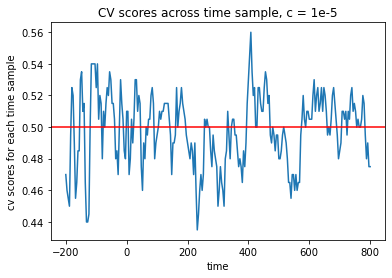

In [59]:
#finding the position of the max scores
max_score_pos = np.unravel_index(np.argmax(time_scores), time_scores.shape)

print("the time with the highest score is:", time_array[max_score_pos])

#plotting
plt.plot(time_array, time_scores) 
plt.axhline(0.5, color = 'r')
plt.xlabel("time")
plt.ylabel("cv scores for each time sample")
plt.title("CV scores across time sample, c = 1e-5")
plt.show()

vi. Now do the same, but with L1 regression - set `C=1e-1` - what are the time points when classification is best? (make a plot)?  

the time with the highest score is: -56


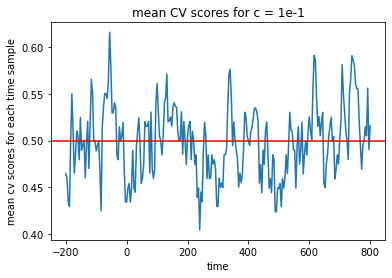

In [60]:
time_scores_c1 = []
lr_new_c1 = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=1e-1, random_state = 2)
X_1_2_equal_c1, y_1_2_equal_c1 = equalize_targets_binary(data_1_2, y_1_2)

for time_ofs in range(data_1_2.shape[2]):
  X_1_2_equal_time = X_1_2_equal_c1[:, :, time_ofs].squeeze() 
  sc.fit(X_1_2_equal_time)
  X_1_2_equal_std = sc.transform(X_1_2_equal_time)
  time_s = cross_val_score(lr_new_c1, X_1_2_equal_std, y_1_2_equal.squeeze(), cv=5)
  score = np.mean(time_s)
  time_scores_c1.append(score)


time_scores_c1 = np.array(time_scores_c1) #this is the mean of accuracy across all time samples 



#finding the position of the max scores
max_score_pos_c1 = np.unravel_index(np.argmax(time_scores_c1), time_scores_c1.shape)
print("the time with the highest score is:", time_array[max_score_pos_c1])



#plotting
plt.plot(time_array, time_scores_c1) 
plt.axhline(0.5, color = 'r')
plt.xlabel("time")
plt.ylabel("mean cv scores for each time sample")
plt.title("mean CV scores for c = 1e-1")
plt.show()



vii. Finally, fit the same models as in Exercise 2.2.vi but now for `data_1_4` and `y_1_4` 
#(create a data set and a target vector that only contains PAS responses 1 and 4). What are the time points when classification is best? Make a plot with time on the x-axis and classification score on the y-axis with a horizontal line at the chance level (what is the chance level for this analysis?)  


In [61]:
#making new data:
list1_4 = np.argwhere((vector_y ==1) | (vector_y == 4))
y_1_4 = vector_y[list1_4,]


#taking the target values for each pass and saved them into data_1_4
data_1_4 = data[list1_4,:,:].squeeze()



In [62]:
### making the exact same thing but now for the new pas1/4 data.
##### fitting the model with c = 1e-1

lr_new_c4 = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=1e-1, random_state = 2)
X_equal_1_4, y_equal_1_4 = equalize_targets_binary(data_1_4, y_1_4)                                                      

 

In [63]:
   
time_scores_4 = []

for time_ofs in range(data_1_4.shape[2]):
  X_1_4_equal_time = X_equal_1_4[:, :, time_ofs].squeeze() 
  sc.fit(X_1_4_equal_time)
  X_1_4_equal_std = sc.transform(X_1_4_equal_time)
  time_s = cross_val_score(lr_new_c4, X_1_4_equal_std, y_equal_1_4.squeeze(), cv=5)
  score = np.mean(time_s)
  time_scores_4.append(score)


time_scores_4 = np.array(time_scores_4) #this is the mean of accuracy across all time samples 


#finding the position of the max scores
max_score_pos_c4 = np.unravel_index(np.argmax(time_scores_4), time_scores_4.shape)
print("the time with the highest score is:", time_array[max_score_pos_c4])


print(time_scores_4.shape)

the time with the highest score is: 236
(251,)


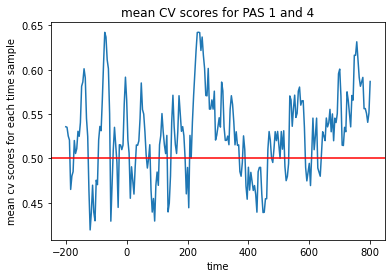

In [64]:


#plotting
plt.plot(time_array, time_scores_4) 
plt.axhline(0.5, color = 'r')
plt.xlabel("time")
plt.ylabel("mean cv scores for each time sample")
plt.title("mean CV scores for PAS 1 and 4")
plt.show()
    

### 3) Is pairwise classification of subjective experience possible? 
#### Any surprises in the classification accuracies, i.e. how does the classification score fore PAS 1 vs 4 compare to the classification score for PAS 1 vs 2?  
#### comment:
    the more similiar the data are the worse the accuracy in the classification
    the greater the difference the better the accuracy 
    - but in this case the difference are greater between pass 1 and 2, which is quite unsual. 

# EXERCISE 3 - Do a Support Vector Machine Classification on all four PAS-ratings  
### 1) Do a Support Vector Machine Classification  

 i. First equalize the number of targets using the function associated with each PAS-rating using the function associated with Exercise 3.1.i  


In [65]:
def equalize_targets(data, y):
    np.random.seed(7)
    targets = np.unique(y)
    counts = list()
    indices = list()
    for target in targets:
        counts.append(np.sum(y == target))
        indices.append(np.where(y == target)[0])
    min_count = np.min(counts)
    first_choice = np.random.choice(indices[0], size=min_count, replace=False)
    second_choice = np.random.choice(indices[1], size=min_count, replace=False)
    third_choice = np.random.choice(indices[2], size=min_count, replace=False)
    fourth_choice = np.random.choice(indices[3], size=min_count, replace=False)
    
    new_indices = np.concatenate((first_choice, second_choice,
                                 third_choice, fourth_choice))
    new_y = y[new_indices]
    new_data = data[new_indices, :, :]
    
    return new_data, new_y

## making new data using this
data_equal, y_equal = equalize_targets(data, vector_y)

#checking the shape:
print(data_equal.shape)
#reshaping to 2d:
data_equal_2d = data_equal.reshape(data_equal.shape[0],-1) #so the time samples is alone, and the others will be multiplied
print(data_equal_2d.shape)

(396, 102, 251)
(396, 25602)


 ii. Run two classifiers, one with a linear kernel and one with a radial basis (other options should be left at their defaults) - the number of features is the number of sensors multiplied the number of samples. Which one is better predicting the category?
-  to be able to test which on of the classifiers perform better, we split up the data so we can both train and test the classifiers:


In [66]:
X_tr, X_te, y_tr, y_te = train_test_split(data_equal_2d, y_equal, test_size=0.2,
                                                    random_state=0)
## standardizing to make it comparable 
sc.fit(data_equal_2d)
X_train_std = sc.transform(X_tr)
X_test_std = sc.transform(X_te)

#importing SVC class to make the different svm
from sklearn.svm import SVC
svml_linear = SVC(kernel = 'linear')### linear kernel
svml_rbf = SVC(kernel = 'rbf')### radial = rbf 


##using the vector functions to find the better prediction:
lin_fit = svml_linear.fit(X_tr, y_tr)
rbf_fit = svml_rbf.fit(X_tr, y_tr)

## finding the accuracy score:
print("the accuracy score of the linear kernel is",(lin_fit.score(X_te, y_te))*100, "%")
print("the accuracy score of the linear kernel is", (rbf_fit.score(X_te, y_te))*100, "%")



the accuracy score of the linear kernel is 21.25 %
the accuracy score of the linear kernel is 28.749999999999996 %


*this is for the rbf better than due to chance (now 25% since 4 passes), while the linear is worse - one could imaging a lot of overfitting going on*

#### iii. Run the sample-by-sample analysis (similar to Exercise 2.2.v) with the best kernel (from Exercise 3.1.ii). Make a plot with time on the x-axis and classification score on the y-axis with a horizontal line at the chance level (what is the chance level for this analysis?)


In [34]:
time_scores_kernel = []
## here we use svml_rbf = SVC(kernel = 'rbf')
## our data is equalized, so we just use the X and y directly 

#since we are to plot it and visualize the entire sample, we will use all data and not only train sets.
for i in range(data_equal.shape[2]):
   x_ker = data_equal[:,:,i]
   sc.fit(x_ker)
   X_ker_std = sc.transform(x_ker)
   cv_score_kernel = cross_val_score(svml_rbf, X_ker_std, y_equal, cv=5)
   mean_score = np.mean(cv_score_kernel)
   time_scores_kernel.append(mean_score)
    


time_scores_kernel = np.array(time_scores_kernel) #this is the mean of accuracy across all time samples 


In [35]:
#finding the position of the max scores
####### making the scores into an array first, and not a list:
time_scores_kernel = np.array(time_scores_kernel)
    
pos_max_kernel = np.unravel_index(np.argmax(time_scores_kernel), time_scores_kernel.shape)

print("the time with the highest accuracy score is:", time_array[pos_max_kernel])

the time with the highest accuracy score is: 704


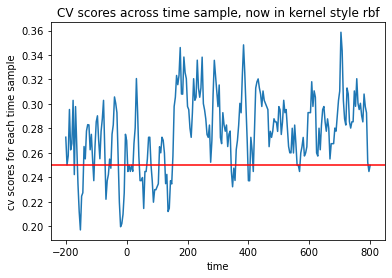

In [36]:
#plotting
plt.plot(time_array, time_scores_kernel) 
plt.axhline(0.25, color = 'r')
plt.xlabel("time")
plt.ylabel("cv scores for each time sample")
plt.title("CV scores across time sample, now in kernel style rbf")
plt.show()

#### iv. Is classification of subjective experience possible at around 200-250 ms? 


*It is possible to predict classification better then by chance in this timeinterval, since it is above the red line. It is not way above, but still quite alright, leading us to suggest: yes it is possible to classify the PAS rating at aroung 200-250.*



## 2) Finally, split the equalized data set (with all four ratings) into a training part and test part, where the test part if 30 % of the trials. Use `train_test_split` from `sklearn.model_selection`  

i. Use the kernel that resulted in the best classification in Exercise 3.1.ii and `fit`the training set and `predict` on the test set. This time your features are the number of sensors multiplied by the number of samples.  


In [37]:
### since we are now to compress sensors and time stamps a new data must be made, where repitions are alone.
data_equal_rep = data_equal.reshape(396, -1)

### we actually did this in 3.1 as well, but will do it again, now with a test set of 30%
X_tr2, X_te2, y_tr2, y_te2 = train_test_split(data_equal_rep, y_equal, test_size=0.3,
                                                    random_state=0)

## standardizing to make it comparable 
sc.fit(data_equal_rep)
X_tr2_std = sc.transform(X_tr2)
X_te2_std = sc.transform(X_te2)

In [38]:
# comparing the accuracy of the classifier, when the test set is 30% of the data.
##using the vector functions to find the better prediction:
rbf_fit = svml_rbf.fit(X_tr2_std, y_tr2)

#printing the accuracy score 
print("the accuracy score of the linear kernel is",(rbf_fit.score(X_te2_std, y_te2))*100, "%, which is better than chance, just like previously")

the accuracy score of the linear kernel is 31.092436974789916 %, which is better than chance, just like previously


ii. Create a _confusion matrix_. It is a 4x4 matrix. The row names and the column names are the PAS-scores. There will thus be 16 entries. The PAS1xPAS1 entry will be the number of actual PAS1, $y_{pas1}$ that were predicted as PAS1, $\hat y_{pas1}$. The PAS1xPAS2 entry will be the number of actual PAS1, $y_{pas1}$ that were predicted as PAS2, $\hat y_{pas2}$ and so on for the remaining 14 entries.  Plot the matrix


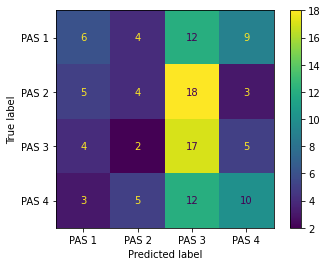

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = rbf_fit.predict(X_te2_std)

cm = confusion_matrix(y_te2, predictions, labels=rbf_fit.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['PAS 1', 'PAS 2', 'PAS 3', 'PAS 4'])
disp.plot()



 #### iii. Based on the confusion matrix, describe how ratings are misclassified and if that makes sense given that ratings should measure the strength/quality of the subjective experience. Is the classifier biased towards specific ratings?  

*Looking at the plot from left to right we see that there are truly 31 sample in each pas, but this is not what is predicted by the kernel.*
*The best prediction is in pass 3, where 17 is rightfully classified.*
*However, it predicts 18 samples of pas 2 to be pas 3, which really is off. It appears as if the kernel are biased towards PAS 3, since this is the what the kernel predicts most often.*

pas 1 = 6/31 correct predictions
pas 2 = 4/31 correct predictions
pas 3 = 17/31 correct predictions
pas 4 = 10/31 correct predictions